In [39]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

# colormap stuff for gradient plotting
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

## Set up parameters, create isochrone grid

In [40]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F200W']
filters = ['m_jwst_F115W', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

# Select nbody6 simulation and snapshot, then convert to physical units and save as a cluster table which SPISEA can interface with

In [41]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff003_00/'
snapshot = Reader.read_snapshot(path_to_data, time = 1.5)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass         isMultiple        compMass             systemMass               e                 log_a               age        
-------------------- ---------- ---------------------- -------------------- -------------------- ------------------ ------------------
0.024886800288565436        0.0                     [] 0.024886800288565436                  nan                nan 0.7576979637377107
 0.19702164656575025        0.0                     []  0.19702164656575025                  nan                nan 0.6640428317478922
   70.05737924296751        0.0                     []    70.05737924296751                  nan                nan 0.8548892392247118
 0.13681434252456479        0.0                     []  0.13681434252456479                  nan                nan  0.918723522740329
                 ...        ...                    ...                  ...                  ...                ...                ...
  0.7164618921919782        1.0   [0.5867114612067746] 

# Read ages of stars, identify bracketing ages for isochrone generation
Also save mass of stars

In [42]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 5.73249351377568
Max log age = 6.175784384679901
Min level age = 540124.0479066774
Max level age = 1498940.4678344727


# Identify binary stars in cluster table, save mass of companion stars

Cluster table always lists binaries last, so finding the index of the first binary suffices

In [43]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
# print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
# print(compMasses)

# Generate isochrones using parameter and age arrays

In [44]:
increment = 0.5e6

if min(level_ages) < 0.5e6:
    start = 0.5e6
else:
    start = (min(level_ages) // increment) * increment

end = (max(level_ages) // increment) * increment + 2 * increment

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[5.69897    6.         6.17609126]
[ 500000. 1000000. 1500000.]


In [45]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


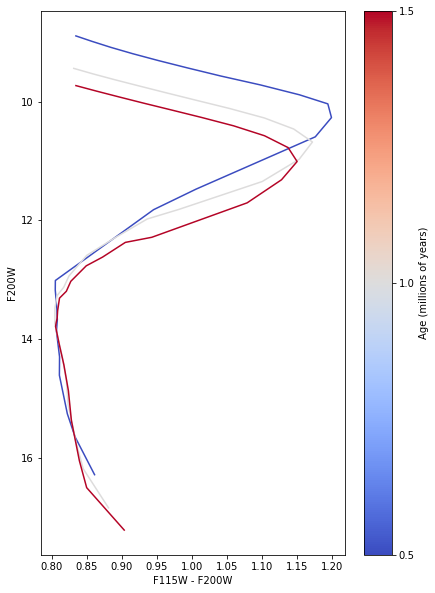

In [46]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)

# Define a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], color=color, label='')
    
py.xlabel('F115W - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()

# Create colorbar legend
norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_age_arr)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

plt.show()

# Use generated SPISEA isochrones to find interpolated magnitudes using the age and mass of each star

Stars outside of the mass range of isochrones are thrown out and not included

In [47]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/')
import interpolator as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
# for i in range(len(stars)):
    # print(stars[i])

# Repeat interpolation on companion stars

Companion stars assumed to be the same age as primary star within system

In [48]:
# perform interpolation on companion stars
companions = np.empty(len(compMasses), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None:
        continue
    companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

for i in range(len(companions)):
    if companions[i] is None:
        continue
    companions[i][0] = companions[i][0] * watts_to_lsun


# Superimpose primary stars and companion stars against isochrones separately

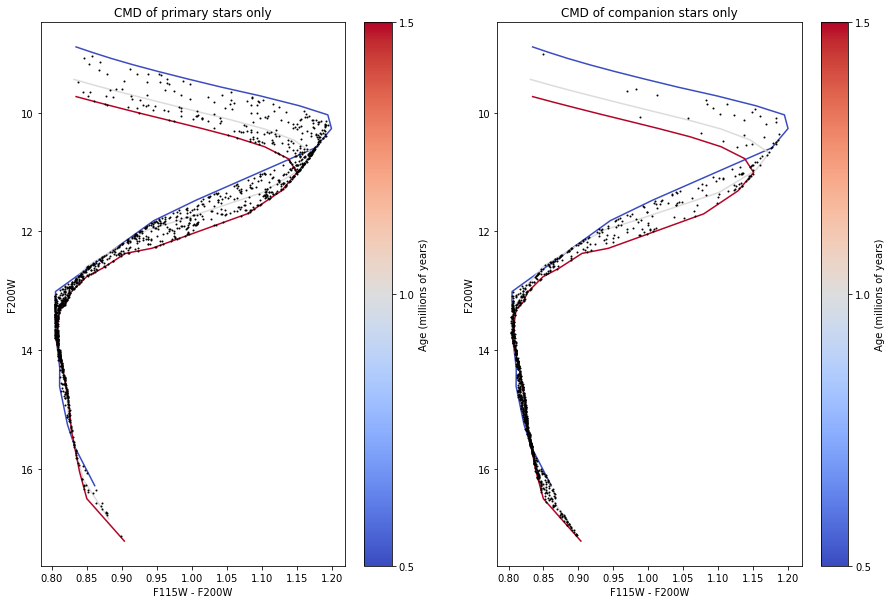

In [49]:
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

# plot primaries
py.subplot(1, 2, 1)

# Define a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], color=color, label='')
    
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()

py.title('CMD of primary stars only')

# Create colorbar legend
norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_age_arr)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])

# plot companions
py.subplot(1, 2, 2)

# Define a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], color=color, label='')
    
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
py.xlabel('F115W - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()

py.title('CMD of companion stars only')

# Create colorbar legend
norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_age_arr)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
plt.show()

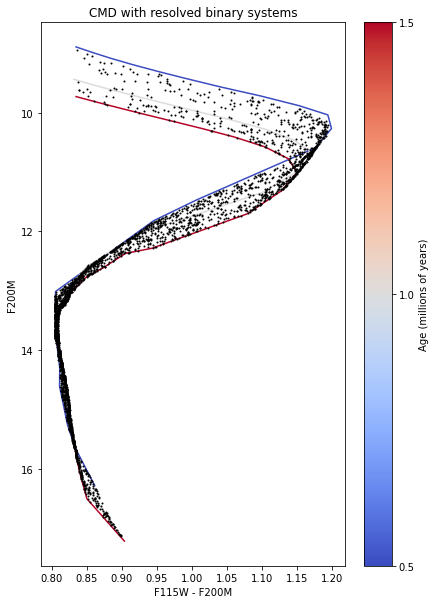

In [58]:
# plot CMD with resolved binary systems
# plot primaries and companions separately
fig, axes = py.subplots(figsize=(15, 10))

py.subplot(1, 2, 1)

# plot isochrones
# Define a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], color=color, label='')
    
# plot primaries
for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot companions
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')
    
    
py.xlabel('F115W - F200M')
py.ylabel('F200M')
py.gca().invert_yaxis()
py.title('CMD with resolved binary systems')

# Create colorbar legend
norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_age_arr)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
plt.show()

In [51]:
# measure spread on CMD with resolved binaries

# Bounding box range 
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 13
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        if color_index < companions[i][3] - companions[i][4] < color_index + color_step and mag_min < companions[i][4] < mag_max:
            mag_bin.append(companions[i][4])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)

Standard deviation for color index 0.85 to 0.90: 0.13
Standard deviation for color index 0.90 to 0.95: 0.13
Standard deviation for color index 0.95 to 1.00: 0.15
Standard deviation for color index 1.00 to 1.05: 0.19
Standard deviation for color index 1.05 to 1.10: 0.19
Average standard deviation: 0.1591805052246533


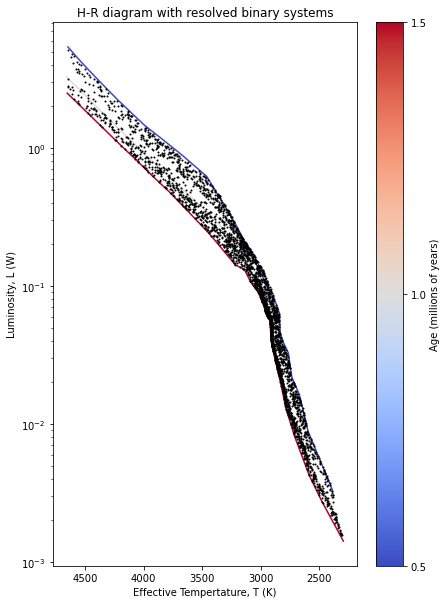

In [63]:
# plot HR diagram
fig, axes = py.subplots(figsize=(15, 10))

py.subplot(1, 2, 1)

# plot isochrones
# Define a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    data_iso_Lsun = instances[i].points['L'] * watts_to_lsun
    py.plot(instances[i].points['Teff'], data_iso_Lsun, color=color, label='')
    
# plot primaries
for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][1], stars[i][0], marker='o', markersize=1, color='k')

# plot companions
for i in range(len(companions)):
    if companions[i] is None:
        continue
    py.plot(companions[i][1], companions[i][0], marker='o', markersize=1, color='k')
    
    
py.xlabel('Effective Tempertature, T (K)')
py.gca().invert_xaxis()
py.ylabel('Luminosity, L (W)')
py.yscale('log')
py.title('H-R diagram with resolved binary systems')

# Create colorbar legend
norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_age_arr)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
plt.show()

# Convert binary stars into unresolved binaries
## Also compute flux ratios of stars and generate histogram
Magnitudes of primary and secondary are converted into flux, which is used to find combined magnitude

In [52]:
# combine magnitudes on binary stars
unresolved_binaries = np.empty(len(companions), dtype=object)

for i in range(len(companions)):
    if stars[i + first_binary] is None or companions[i] is None:
        continue
    
    flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
    flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
    mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)
    
    flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
    flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
    mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)
    
    unresolved_binaries[i] = [mag1, mag2]

# Generate CMD using star array, plus unresolved binaries
Compare to CMD generated by simply multiplying each star's flux by 2

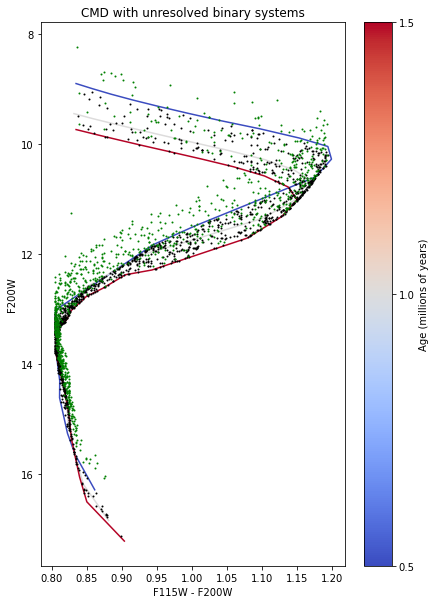

In [64]:
fig, axes = py.subplots(figsize=(15, 10))

py.subplot(1, 2, 1)

# CMD with unresolved binaries
# Define a colormap
cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

for i in range(len(log_age_arr)):
    color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
    py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
           instances[i].points[filters[1]], color=color, label='')

# plot single stars first
for i in range(0, first_binary):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

# plot unresolve binaries
for i in range(len(unresolved_binaries)):
    if unresolved_binaries[i] is None:
        continue
    py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
            unresolved_binaries[i][1], marker='o', markersize=1, color='green')

py.xlabel('F115W - F200W')
py.ylabel('F200W')
py.gca().invert_yaxis()
py.title('CMD with unresolved binary systems')

# Create colorbar legend
norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_age_arr)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
plt.show()

In [54]:
# Bounding box range 
color_min = 0.85
color_max = 1.05
mag_min = 11
mag_max = 13
color_step = 0.05

mags = []
bin_std_deviations = []

# Iterate over color bins
for color_index in np.arange(color_min, color_max, color_step):
    mag_bin = []
    count = 0
    
    # Iterate over stars within the current color bin
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        if color_index < stars[i][3] - stars[i][4] < color_index + color_step and mag_min < stars[i][4] < mag_max:
            mag_bin.append(stars[i][4])
            count += 1

    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        if color_index < stars[i + first_binary][3] - stars[i + first_binary][4] < color_index + color_step and mag_min < unresolved_binaries[i][1] < mag_max:
            mag_bin.append(unresolved_binaries[i][1])
            count += 1

    bin_std = np.std(mag_bin)
    bin_std_deviations.append(bin_std)
    
    print(f"Standard deviation for color index {color_index:.2f} to {color_index + color_step:.2f}: {bin_std:.2f}")

# Compute the average standard deviation
average_std = np.mean(bin_std_deviations)
print("Average standard deviation:", average_std)

Standard deviation for color index 0.85 to 0.90: 0.26
Standard deviation for color index 0.90 to 0.95: 0.22
Standard deviation for color index 0.95 to 1.00: 0.23
Standard deviation for color index 1.00 to 1.05: 0.23
Standard deviation for color index 1.05 to 1.10: 0.20
Average standard deviation: 0.22796576817348221
